# Deep Reinforcement Learning

- Playing CartPole with the Actor-Critic Method
- Deep Deterministic Policy Gradient (DDPG)for the classic Inverted Pendulum control problem
- Deep Q-Learning for Atari Breakout
- Proximal Policy Optimization


# Playing CartPole with the Actor-Critic Method

This tutorial demonstrates how to implement the [Actor-Critic](https://papers.nips.cc/paper/1786-actor-critic-algorithms.pdf) method to train an agent on the [Open AI Gym](https://gym.openai.com/) CartPole-V0 environment.
This is built on [policy gradient methods](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf) of reinforcement learning. 


**Actor-Critic methods**

Actor-Critic methods are [temporal difference (TD) learning](https://en.wikipedia.org/wiki/Temporal_difference_learning) methods that represent the policy function independent of the value function. 

A policy function (or policy) returns a probability distribution over actions that the agent can take based on the given state.
A value function determines the expected return for an agent starting at a given state and acting according to a particular policy forever after.

In the Actor-Critic method, the policy is referred to as the *actor* that proposes a set of possible actions given a state, and the estimated value function is referred to as the *critic*, which evaluates actions taken by the *actor* based on the given policy.

In this tutorial, both the *Actor* and *Critic* will be represented using one neural network with two outputs.


**CartPole-v0**

In the [CartPole-v0 environment](https://gym.openai.com/envs/CartPole-v0), a pole is attached to a cart moving along a frictionless track. 
The pole starts upright and the goal of the agent is to prevent it from falling over by applying a force of -1 or +1 to the cart. 
A reward of +1 is given for every time step the pole remains upright.
An episode ends when (1) the pole is more than 15 degrees from vertical or (2) the cart moves more than 2.4 units from the center.

![title](https://www.tensorflow.org/tutorials/reinforcement_learning/images/cartpole-v0.gif)

<center>
  <figure>
    <image src="https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic_files/output_TLd720SejKmf_0.gif">
    <figcaption>
      Trained actor-critic model in Cartpole-v0 environment
    </figcaption>
  </figure>
</center>


The problem is considered "solved" when the average total reward for the episode reaches 195 over 100 consecutive trials.

## Setup

Import necessary packages and configure global settings.


In [1]:
!pip install gym
!pip install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 32.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827728 sha256=648482f22aca008853ed471c6d604f5ec8537276b81cb25f87bd2a85637334cf
  Stored in directory: /home/ubuntu/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl.metadata (24 kB)
Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl (887.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0
    Uninstalling torch-2.6.0:
      Successfully uninstalled torch-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchmetrics 1.7.0 requires 

In [2]:
%%bash
# Install additional packages for visualization
# sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install pyvirtualdisplay > /dev/null 2>&1

In [3]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from collections import deque
import random

# Create the environment
env = gym.make("CartPole-v0")

# Set seed for experiment reproducibility
seed = 42
env.reset(seed=seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

/opt/conda/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/torch/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


## Model

The *Actor* and *Critic* will be modeled using one neural network that generates the action probabilities and critic value respectively. This tutorial uses model subclassing to define the model. 

During the forward pass, the model will take in the state as the input and will output both action probabilities and critic value $V$, which models the state-dependent [value function](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#value-functions). The goal is to train a model that chooses actions based on a policy $\pi$ that maximizes expected [return](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#reward-and-return).

For Cartpole-v0, there are four values representing the state: cart position, cart-velocity, pole angle and pole velocity respectively. The agent can take two actions to push the cart left (0) and right (1) respectively.

Refer to [OpenAI Gym's CartPole-v0 wiki page](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf) for more information.


In [4]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size):
        super(ActorCritic, self).__init__()
        self.common = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU()
        )
        self.actor = nn.Linear(hidden_size, num_actions)
        self.critic = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.common(x)
        return self.actor(x), self.critic(x)

In [5]:
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n
hidden_size = 128

model = ActorCritic(num_inputs, num_actions, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Training

To train the agent, you will follow these steps:

1. Run the agent on the environment to collect training data per episode.
2. Compute expected return at each time step.
3. Compute the loss for the combined actor-critic model.
4. Compute gradients and update network parameters.
5. Repeat 1-4 until either success criterion or max episodes has been reached.


### 1. Collecting training data

As in supervised learning, in order to train the actor-critic model, you need
to have training data. However, in order to collect such data, the model would
need to be "run" in the environment.

Training data is collected for each episode. Then at each time step, the model's forward pass will be run on the environment's state in order to generate action probabilities and the critic value based on the current policy parameterized by the model's weights.

The next action will be sampled from the action probabilities generated by the model, which would then be applied to the environment, causing the next state and reward to be generated.

In [6]:
def env_step(action):
    state_info = env.step(action)
    if isinstance(state_info, tuple):
        state, reward, done, _ = state_info
    else:
        state, reward, done = state_info
    return torch.tensor(state, dtype=torch.float32), reward, done


In [7]:
def run_episode(model, max_steps):
    state_info = env.reset()
    state = torch.tensor(state_info[0] if isinstance(state_info, tuple) else state_info, dtype=torch.float32)
    log_probs, values, rewards = [], [], []

    for _ in range(max_steps):
        logits, value = model(state)
        action_probs = torch.softmax(logits, dim=-1)
        action = torch.multinomial(action_probs, 1).item()

        # Append log probabilities and values
        log_probs.append(torch.log(action_probs[action]).unsqueeze(0))
        values.append(value)

        state_info = env.step(action)
        if isinstance(state_info, tuple):
            state, reward, done, *_ = state_info
        else:
            state, reward, done = state_info

        state = torch.tensor(state, dtype=torch.float32)
        rewards.append(reward)

        if done:
            break

    return log_probs, values, rewards


### 2. Computing expected returns

The sequence of rewards for each timestep $t$, $\{r_{t}\}^{T}_{t=1}$ collected during one episode is converted into a sequence of expected returns $\{G_{t}\}^{T}_{t=1}$ in which the sum of rewards is taken from the current timestep $t$ to $T$ and each reward is multiplied with an exponentially decaying discount factor $\gamma$:

$$G_{t} = \sum^{T}_{t'=t} \gamma^{t'-t}r_{t'}$$

Since $\gamma\in(0,1)$, rewards further out from the current timestep are given less weight.

Intuitively, expected return simply implies that rewards now are better than rewards later. In a mathematical sense, it is to ensure that the sum of the rewards converges.

To stabilize training, the resulting sequence of returns is also standardized (i.e. to have zero mean and unit standard deviation).


In [8]:
def compute_returns(rewards, gamma=0.99):
    returns = []
    discounted_sum = 0
    for reward in reversed(rewards):
        discounted_sum = reward + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    returns = torch.tensor(returns, dtype=torch.float32)
    return (returns - returns.mean()) / (returns.std() + eps)

### 3. The actor-critic loss

Since a hybrid actor-critic model is used, the chosen loss function is a combination of actor and critic losses for training, as shown below:

$$L = L_{actor} + L_{critic}$$

#### Actor loss

The actor loss is based on [policy gradients with the critic as a state dependent baseline](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s) and computed with single-sample (per-episode) estimates.

$$L_{actor} = -\sum^{T}_{t=1} log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$

where:
- $T$: the number of timesteps per episode, which can vary per episode
- $s_{t}$: the state at timestep $t$
- $a_{t}$: chosen action at timestep $t$ given state $s$
- $\pi_{\theta}$: is the policy (actor) parameterized by $\theta$
- $V^{\pi}_{\theta}$: is the value function (critic) also parameterized by $\theta$
- $G = G_{t}$: the expected return for a given state, action pair at timestep $t$

A negative term is added to the sum since the idea is to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

<br>

##### Advantage

The $G - V$ term in our $L_{actor}$ formulation is called the [advantage](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions), which indicates how much better an action is given a particular state over a random action selected according to the policy $\pi$ for that state.

While it's possible to exclude a baseline, this may result in high variance during training. And the nice thing about choosing the critic $V$ as a baseline is that it trained to be as close as possible to $G$, leading to a lower variance.

In addition, without the critic, the algorithm would try to increase probabilities for actions taken on a particular state based on expected return, which may not make much of a difference if the relative probabilities between actions remain the same.

For instance, suppose that two actions for a given state would yield the same expected return. Without the critic, the algorithm would try to raise the probability of these actions based on the objective $J$. With the critic, it may turn out that there's no advantage ($G - V = 0$) and thus no benefit gained in increasing the actions' probabilities and the algorithm would set the gradients to zero.

<br>

#### Critic loss

Training $V$ to be as close possible to $G$ can be set up as a regression problem with the following loss function:

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

where $L_{\delta}$ is the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers in data than squared-error loss.


In [9]:
def compute_loss(log_probs, values, returns):
    advantage = returns - torch.cat(values)
    actor_loss = -torch.sum(torch.cat(log_probs) * advantage.detach())
    critic_loss = advantage.pow(2).mean()
    return actor_loss + critic_loss

### 4. Defining the training step to update parameters

All of the steps above are combined into a training step that is run every episode. All steps leading up to the loss function are executed with the `tf.GradientTape` context to enable automatic differentiation.

This tutorial uses the Adam optimizer to apply the gradients to the model parameters.

The sum of the undiscounted rewards, `episode_reward`, is also computed in this step. This value will be used later on to evaluate if the success criterion is met.

In [10]:
def train_step(model, optimizer, gamma=0.99, max_steps_per_episode=1000):
    log_probs, values, rewards = run_episode(model, max_steps_per_episode)
    returns = compute_returns(rewards, gamma)

    loss = compute_loss(log_probs, values, returns)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return sum(rewards)

### 5. Run the training loop

Training is executed by running the training step until either the success criterion or maximum number of episodes is reached.  

A running record of episode rewards is kept in a queue. Once 100 trials are reached, the oldest reward is removed at the left (tail) end of the queue and the newest one is added at the head (right). A running sum of the rewards is also maintained for computational efficiency. 

Depending on your runtime, training can finish in less than a minute.

In [11]:
min_episodes_criterion = 100
max_episodes = 10000
reward_threshold = 195
running_reward = 0

episode_rewards = deque(maxlen=min_episodes_criterion)

for i in range(max_episodes):
    episode_reward = train_step(model, optimizer)
    episode_rewards.append(episode_reward)
    running_reward = np.mean(episode_rewards)

    if running_reward > reward_threshold and i >= min_episodes_criterion:
        print(f'Solved at episode {i}: average reward: {running_reward:.2f}!')
        break

/opt/conda/envs/torch/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Solved at episode 100: average reward: 350.85!


## Visualization

After training, it would be good to visualize how the model performs in the environment. You can run the cells below to generate a GIF animation of one episode run of the model. Note that additional packages need to be installed for OpenAI Gym to render the environment's images correctly in Colab.

In [12]:
!pip install pyvirtualdisplay xvfbwrapper
!pip install gym[classic_control]
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 98.6 MB/s eta 0:00:00


In [13]:
import torch
from PIL import Image

def render_episode(env, model, max_steps):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    state = torch.tensor(state, dtype=torch.float32)
    frames = []

    for _ in range(max_steps):
        frame = env.render()
        frames.append(Image.fromarray(frame))

        with torch.no_grad():
            logits = model(state.unsqueeze(0))[0]
        action = torch.argmax(torch.softmax(logits, dim=-1)).item()

        state, _, done, *_ = env.step(action)
        state = torch.tensor(state, dtype=torch.float32)
        if done:
            break

    return frames

env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = render_episode(env, model, max_steps=1000)
frames[0].save('cartpole.gif', save_all=True, append_images=frames[1:], loop=0, duration=40)


![title](https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic_files/output_TLd720SejKmf_0.gif)


# Deep Deterministic Policy Gradient (DDPG)for the classic Inverted Pendulum control problem

## Introduction

Deep Deterministic Policy Gradient (DDPG) is a model-free off-policy algorithm for learning continous actions.

It combines ideas from DPG (Deterministic Policy Gradient) and DQN (Deep Q-Network). It uses Experience Replay and slow-learning target networks from DQN, and it is based on DPG, which can operate over continuous action spaces.

This tutorial closely follow this paper - Continuous control with deep reinforcement learning https://arxiv.org/pdf/1509.02971.pdf


## Problem

We are trying to solve the classic Inverted Pendulum control problem. In this setting, we can take only two actions: swing left or swing right.

What make this problem challenging for Q-Learning Algorithms is that actions are continuous instead of being discrete. That is, instead of using two discrete actions like -1 or +1, we have to select from infinite actions ranging from -2 to +2.

## Quick theory
Just like the Actor-Critic method, we have two networks:

Actor - It proposes an action given a state.
Critic - It predicts if the action is good (positive value) or bad (negative value) given a state and an action.
DDPG uses two more techniques not present in the original DQN:

First, it uses two Target networks.

Why? Because it add stability to training. In short, we are learning from estimated targets and Target networks are updated slowly, hence keeping our estimated targets stable.

Conceptually, this is like saying, "I have an idea of how to play this well, I'm going to try it out for a bit until I find something better", as opposed to saying "I'm going to re-learn how to play this entire game after every move". See this StackOverflow answer.

Second, it uses Experience Replay.

We store list of tuples (state, action, reward, next_state), and instead of learning only from recent experience, we learn from sampling all of our experience accumulated so far.

Now, let's see how is it implemented.

We use OpenAIGym to create the environment. We will use the upper_bound parameter to scale our actions later.

In [14]:
import gym
import matplotlib.pyplot as plt

env = gym.make("Pendulum-v1")
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("State space:", num_states)
print("Action space:", num_actions)

State space: 3
Action space: 1


To implement better exploration by the Actor network, we use noisy perturbations, specifically an Ornstein-Uhlenbeck process for generating noise, as described in the paper. It samples noise from a correlated normal distribution.

In [15]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * torch.sqrt(torch.tensor(self.dt)) * torch.randn_like(self.mean)
        )
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x_initial if self.x_initial is not None else torch.zeros_like(self.mean)

The Buffer class implements Experience Replay.

![title](https://i.imgur.com/mS6iGyJ.jpg)


**Critic loss** - Mean Squared Error of y - Q(s, a) where y is the expected return as seen by the Target network, and Q(s, a) is action value predicted by the Critic network. y is a moving target that the critic model tries to achieve; we make this target stable by updating the Target model slowly.

**Actor loss** - This is computed using the mean of the value given by the Critic network for the actions taken by the Actor network. We seek to maximize this quantity.

Hence we update the Actor network so that it produces actions that get the maximum predicted value as seen by the Critic, for a given state.

In [16]:
import numpy as np

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    def sample(self):
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = torch.tensor(self.state_buffer[batch_indices], dtype=torch.float32)
        action_batch = torch.tensor(self.action_buffer[batch_indices], dtype=torch.float32)
        reward_batch = torch.tensor(self.reward_buffer[batch_indices], dtype=torch.float32)
        next_state_batch = torch.tensor(self.next_state_buffer[batch_indices], dtype=torch.float32)

        return state_batch, action_batch, reward_batch, next_state_batch

Here we define the Actor and Critic networks. These are basic Dense models with ReLU activation.

Note: We need the initialization for last layer of the Actor to be between -0.003 and 0.003 as this prevents us from getting 1 or -1 output values in the initial stages, which would squash our gradients to zero, as we use the tanh activation.

def get_actor():

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, action_bound):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, action_dim)
        self.action_bound = action_bound

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.out(x)) * self.action_bound
        return x

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

In [18]:
actor = Actor(num_states, num_actions, upper_bound)
critic = Critic(num_states, num_actions)

actor_target = Actor(num_states, num_actions, upper_bound)
critic_target = Critic(num_states, num_actions)

actor_target.load_state_dict(actor.state_dict())
critic_target.load_state_dict(critic.state_dict())

actor_optimizer = torch.optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=0.002)

Now we implement our main training loop, and iterate over episodes. We sample actions using policy() and train with learn() at each time step, along with updating the Target networks at a rate tau.



Training Progress:   1%|          | 1/100 [00:02<04:34,  2.77s/it]

Episode 0, Avg Reward: -6462.32644833403


Training Progress:   2%|▏         | 2/100 [00:05<04:38,  2.84s/it]

Episode 1, Avg Reward: -7004.118412147303


Training Progress:   3%|▎         | 3/100 [00:08<04:38,  2.87s/it]

Episode 2, Avg Reward: -6533.6602679720645


Training Progress:   4%|▍         | 4/100 [00:11<04:36,  2.88s/it]

Episode 3, Avg Reward: -6014.594160592539


Training Progress:   5%|▌         | 5/100 [00:14<04:34,  2.89s/it]

Episode 4, Avg Reward: -4864.77349032798


Training Progress:   6%|▌         | 6/100 [00:17<04:31,  2.89s/it]

Episode 5, Avg Reward: -4134.487266891069


Training Progress:   7%|▋         | 7/100 [00:20<04:28,  2.88s/it]

Episode 6, Avg Reward: -3580.3606354599474


Training Progress:   8%|▊         | 8/100 [00:22<04:25,  2.88s/it]

Episode 7, Avg Reward: -3163.840674195263


Training Progress:   9%|▉         | 9/100 [00:25<04:22,  2.88s/it]

Episode 8, Avg Reward: -2826.425721647952


Training Progress:  10%|█         | 10/100 [00:28<04:18,  2.88s/it]

Episode 9, Avg Reward: -2555.9467279160594


Training Progress:  11%|█         | 11/100 [00:31<04:15,  2.87s/it]

Episode 10, Avg Reward: -2334.2238062504525


Training Progress:  12%|█▏        | 12/100 [00:34<04:12,  2.87s/it]

Episode 11, Avg Reward: -2150.6511577195583


Training Progress:  13%|█▎        | 13/100 [00:37<04:09,  2.87s/it]

Episode 12, Avg Reward: -1985.8952476386887


Training Progress:  14%|█▍        | 14/100 [00:40<04:07,  2.87s/it]

Episode 13, Avg Reward: -1852.9986365272073


Training Progress:  15%|█▌        | 15/100 [00:43<04:04,  2.87s/it]

Episode 14, Avg Reward: -1738.4160472024384


Training Progress:  16%|█▌        | 16/100 [00:45<04:01,  2.87s/it]

Episode 15, Avg Reward: -1637.143891998895


Training Progress:  17%|█▋        | 17/100 [00:48<03:58,  2.87s/it]

Episode 16, Avg Reward: -1571.2771260231766


Training Progress:  18%|█▊        | 18/100 [00:51<03:55,  2.88s/it]

Episode 17, Avg Reward: -1512.9434600418338


Training Progress:  19%|█▉        | 19/100 [00:54<03:53,  2.88s/it]

Episode 18, Avg Reward: -1486.1666596664697


Training Progress:  20%|██        | 20/100 [00:57<03:50,  2.88s/it]

Episode 19, Avg Reward: -1470.515638451796


Training Progress:  21%|██        | 21/100 [01:00<03:47,  2.88s/it]

Episode 20, Avg Reward: -1462.6818372121343


Training Progress:  22%|██▏       | 22/100 [01:03<03:44,  2.87s/it]

Episode 21, Avg Reward: -1402.635200458159


Training Progress:  23%|██▎       | 23/100 [01:06<03:41,  2.87s/it]

Episode 22, Avg Reward: -1412.960447047984


Training Progress:  24%|██▍       | 24/100 [01:08<03:38,  2.87s/it]

Episode 23, Avg Reward: -1376.1658111648758


Training Progress:  25%|██▌       | 25/100 [01:11<03:35,  2.87s/it]

Episode 24, Avg Reward: -1336.566821264356


Training Progress:  26%|██▌       | 26/100 [01:14<03:32,  2.87s/it]

Episode 25, Avg Reward: -1295.522222751685


Training Progress:  27%|██▋       | 27/100 [01:17<03:29,  2.87s/it]

Episode 26, Avg Reward: -1256.2909400034637


Training Progress:  28%|██▊       | 28/100 [01:20<03:27,  2.88s/it]

Episode 27, Avg Reward: -1220.354733321065


Training Progress:  29%|██▉       | 29/100 [01:23<03:24,  2.87s/it]

Episode 28, Avg Reward: -1189.6668907484977


Training Progress:  30%|███       | 30/100 [01:26<03:21,  2.87s/it]

Episode 29, Avg Reward: -1158.3809422009303


Training Progress:  31%|███       | 31/100 [01:29<03:18,  2.87s/it]

Episode 30, Avg Reward: -1132.1061266502875


Training Progress:  32%|███▏      | 32/100 [01:31<03:15,  2.87s/it]

Episode 31, Avg Reward: -1100.8800390730264


Training Progress:  33%|███▎      | 33/100 [01:34<03:12,  2.87s/it]

Episode 32, Avg Reward: -1071.6818569939044


Training Progress:  34%|███▍      | 34/100 [01:37<03:09,  2.87s/it]

Episode 33, Avg Reward: -1047.4389182127682


Training Progress:  35%|███▌      | 35/100 [01:40<03:06,  2.87s/it]

Episode 34, Avg Reward: -1024.420284523407


Training Progress:  36%|███▌      | 36/100 [01:43<03:03,  2.87s/it]

Episode 35, Avg Reward: -1002.3695292269074


Training Progress:  37%|███▋      | 37/100 [01:46<03:02,  2.89s/it]

Episode 36, Avg Reward: -984.501472215017


Training Progress:  38%|███▊      | 38/100 [01:49<03:00,  2.91s/it]

Episode 37, Avg Reward: -961.6430523412397


Training Progress:  39%|███▉      | 39/100 [01:52<02:57,  2.91s/it]

Episode 38, Avg Reward: -937.0851100338579


Training Progress:  40%|████      | 40/100 [01:55<02:54,  2.92s/it]

Episode 39, Avg Reward: -916.8103743980613


Training Progress:  41%|████      | 41/100 [01:58<02:52,  2.92s/it]

Episode 40, Avg Reward: -758.3465389305578


Training Progress:  42%|████▏     | 42/100 [02:01<02:49,  2.92s/it]

Episode 41, Avg Reward: -578.9913840724305


Training Progress:  43%|████▎     | 43/100 [02:03<02:46,  2.92s/it]

Episode 42, Avg Reward: -445.9608812788316


Training Progress:  44%|████▍     | 44/100 [02:06<02:43,  2.92s/it]

Episode 43, Avg Reward: -353.078609404524


Training Progress:  45%|████▌     | 45/100 [02:09<02:40,  2.92s/it]

Episode 44, Avg Reward: -352.63011520913744


Training Progress:  46%|████▌     | 46/100 [02:12<02:37,  2.92s/it]

Episode 45, Avg Reward: -347.0128099540527


Training Progress:  47%|████▋     | 47/100 [02:15<02:34,  2.91s/it]

Episode 46, Avg Reward: -343.90625610785844


Training Progress:  48%|████▊     | 48/100 [02:18<02:31,  2.91s/it]

Episode 47, Avg Reward: -346.54086241210143


Training Progress:  49%|████▉     | 49/100 [02:21<02:28,  2.91s/it]

Episode 48, Avg Reward: -349.6826200321224


Training Progress:  50%|█████     | 50/100 [02:24<02:25,  2.91s/it]

Episode 49, Avg Reward: -350.1557340984581


Training Progress:  51%|█████     | 51/100 [02:27<02:22,  2.91s/it]

Episode 50, Avg Reward: -353.5056417563313


Training Progress:  52%|█████▏    | 52/100 [02:30<02:19,  2.91s/it]

Episode 51, Avg Reward: -353.70822018719724


Training Progress:  53%|█████▎    | 53/100 [02:33<02:17,  2.91s/it]

Episode 52, Avg Reward: -356.9240187837839


Training Progress:  54%|█████▍    | 54/100 [02:35<02:13,  2.91s/it]

Episode 53, Avg Reward: -359.7950979984814


Training Progress:  55%|█████▌    | 55/100 [02:38<02:11,  2.91s/it]

Episode 54, Avg Reward: -359.9120699364153


Training Progress:  56%|█████▌    | 56/100 [02:41<02:08,  2.91s/it]

Episode 55, Avg Reward: -363.79114207702395


Training Progress:  57%|█████▋    | 57/100 [02:44<02:05,  2.92s/it]

Episode 56, Avg Reward: -354.9374051276065


Training Progress:  58%|█████▊    | 58/100 [02:47<02:02,  2.92s/it]

Episode 57, Avg Reward: -348.88247051072995


Training Progress:  59%|█████▉    | 59/100 [02:50<01:59,  2.93s/it]

Episode 58, Avg Reward: -330.4508973268738


Training Progress:  60%|██████    | 60/100 [02:53<01:57,  2.93s/it]

Episode 59, Avg Reward: -302.1891134518053


Training Progress:  61%|██████    | 61/100 [02:56<01:54,  2.94s/it]

Episode 60, Avg Reward: -295.34697346334445


Training Progress:  62%|██████▏   | 62/100 [02:59<01:51,  2.95s/it]

Episode 61, Avg Reward: -296.54621754069626


Training Progress:  63%|██████▎   | 63/100 [03:02<01:49,  2.96s/it]

Episode 62, Avg Reward: -273.13772485751485


Training Progress:  64%|██████▍   | 64/100 [03:05<01:47,  3.00s/it]

Episode 63, Avg Reward: -271.4091907007495


Training Progress:  65%|██████▌   | 65/100 [03:08<01:44,  3.00s/it]

Episode 64, Avg Reward: -269.8589885500133


Training Progress:  66%|██████▌   | 66/100 [03:11<01:41,  3.00s/it]

Episode 65, Avg Reward: -292.36825293967206


Training Progress:  67%|██████▋   | 67/100 [03:14<01:39,  3.01s/it]

Episode 66, Avg Reward: -318.81665674373755


Training Progress:  68%|██████▊   | 68/100 [03:17<01:36,  3.02s/it]

Episode 67, Avg Reward: -316.17543874077387


Training Progress:  69%|██████▉   | 69/100 [03:20<01:34,  3.04s/it]

Episode 68, Avg Reward: -308.6183475375575


Training Progress:  70%|███████   | 70/100 [03:23<01:31,  3.05s/it]

Episode 69, Avg Reward: -306.3981451577188


Training Progress:  71%|███████   | 71/100 [03:26<01:29,  3.08s/it]

Episode 70, Avg Reward: -301.68782808463504


Training Progress:  72%|███████▏  | 72/100 [03:30<01:26,  3.10s/it]

Episode 71, Avg Reward: -305.73982676375743


Training Progress:  73%|███████▎  | 73/100 [03:33<01:24,  3.12s/it]

Episode 72, Avg Reward: -306.3677473062523


Training Progress:  74%|███████▍  | 74/100 [03:36<01:21,  3.15s/it]

Episode 73, Avg Reward: -301.27361832915244


Training Progress:  75%|███████▌  | 75/100 [03:39<01:19,  3.18s/it]

Episode 74, Avg Reward: -302.42343410923314


Training Progress:  76%|███████▌  | 76/100 [03:42<01:16,  3.20s/it]

Episode 75, Avg Reward: -303.9277641527827


Training Progress:  77%|███████▋  | 77/100 [03:46<01:14,  3.23s/it]

Episode 76, Avg Reward: -305.2281711139417


Training Progress:  78%|███████▊  | 78/100 [03:49<01:11,  3.25s/it]

Episode 77, Avg Reward: -303.7820850268974


Training Progress:  79%|███████▉  | 79/100 [03:52<01:08,  3.27s/it]

Episode 78, Avg Reward: -308.1176201406935


Training Progress:  80%|████████  | 80/100 [03:56<01:05,  3.28s/it]

Episode 79, Avg Reward: -305.8706916500237


Training Progress:  81%|████████  | 81/100 [03:59<01:02,  3.30s/it]

Episode 80, Avg Reward: -306.9420139593609


Training Progress:  82%|████████▏ | 82/100 [04:02<00:59,  3.31s/it]

Episode 81, Avg Reward: -327.06658952928


Training Progress:  83%|████████▎ | 83/100 [04:06<00:56,  3.32s/it]

Episode 82, Avg Reward: -324.1935565830957


Training Progress:  84%|████████▍ | 84/100 [04:09<00:53,  3.32s/it]

Episode 83, Avg Reward: -318.5074496829615


Training Progress:  85%|████████▌ | 85/100 [04:12<00:50,  3.35s/it]

Episode 84, Avg Reward: -315.3108580899605


Training Progress:  86%|████████▌ | 86/100 [04:16<00:47,  3.37s/it]

Episode 85, Avg Reward: -318.2438501505682


Training Progress:  87%|████████▋ | 87/100 [04:19<00:43,  3.37s/it]

Episode 86, Avg Reward: -318.30010573236234


Training Progress:  88%|████████▊ | 88/100 [04:23<00:40,  3.39s/it]

Episode 87, Avg Reward: -313.28741069883336


Training Progress:  89%|████████▉ | 89/100 [04:26<00:37,  3.39s/it]

Episode 88, Avg Reward: -310.57492107428845


Training Progress:  90%|█████████ | 90/100 [04:29<00:34,  3.40s/it]

Episode 89, Avg Reward: -310.3214259119915


Training Progress:  91%|█████████ | 91/100 [04:33<00:30,  3.39s/it]

Episode 90, Avg Reward: -312.2611874599471


Training Progress:  92%|█████████▏| 92/100 [04:36<00:27,  3.38s/it]

Episode 91, Avg Reward: -312.33620979752146


Training Progress:  93%|█████████▎| 93/100 [04:40<00:23,  3.37s/it]

Episode 92, Avg Reward: -312.2310935304443


Training Progress:  94%|█████████▍| 94/100 [04:43<00:20,  3.37s/it]

Episode 93, Avg Reward: -309.307850118033


Training Progress:  95%|█████████▌| 95/100 [04:46<00:16,  3.38s/it]

Episode 94, Avg Reward: -311.64734214780253


Training Progress:  96%|█████████▌| 96/100 [04:50<00:13,  3.37s/it]

Episode 95, Avg Reward: -305.0061016719691


Training Progress:  97%|█████████▋| 97/100 [04:53<00:10,  3.37s/it]

Episode 96, Avg Reward: -304.33078031143157


Training Progress:  98%|█████████▊| 98/100 [04:56<00:06,  3.37s/it]

Episode 97, Avg Reward: -304.7366856232059


Training Progress:  99%|█████████▉| 99/100 [05:00<00:03,  3.38s/it]

Episode 98, Avg Reward: -301.43223753376236


Training Progress: 100%|██████████| 100/100 [05:03<00:00,  3.04s/it]

Episode 99, Avg Reward: -306.8189953799518


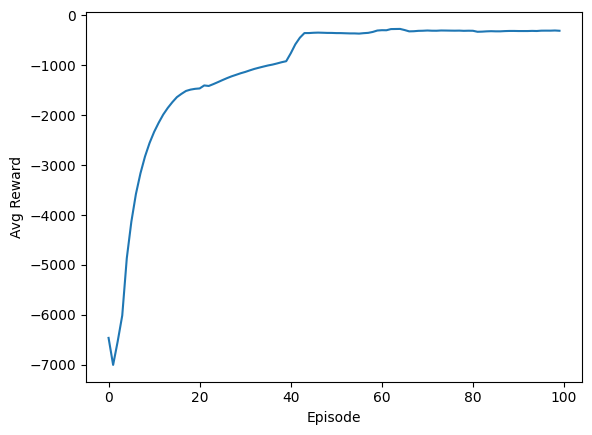

In [19]:
from tqdm import tqdm  # Import the tqdm library for progress display

ep_reward_list = []
avg_reward_list = []

buffer = Buffer(50000, 64)
ou_noise = OUActionNoise(mean=torch.zeros(1), std_deviation=0.2 * torch.ones(1))

def policy(state, noise):
    # Use the actor network to predict actions with added noise for exploration
    with torch.no_grad():
        action = actor(state) + noise()
    return action.clamp(lower_bound, upper_bound)

# Set a maximum step limit per episode to prevent infinite loops
MAX_STEPS_PER_EPISODE = 1000

# Wrap the main loop with tqdm for progress tracking
for ep in tqdm(range(100), desc="Training Progress"):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]  # Unpack if the environment returns a tuple
    state = torch.tensor(state, dtype=torch.float32)
    episodic_reward = 0

    for step in range(MAX_STEPS_PER_EPISODE):  # Add a step limit
        # Select action using the policy and apply it to the environment
        action = policy(state.unsqueeze(0), ou_noise).squeeze(0).numpy()
        next_state, reward, done, *_ = env.step(action)

        # Record the transition in the replay buffer
        buffer.record((state.numpy(), action, reward, next_state))
        state = torch.tensor(next_state, dtype=torch.float32)

        # Perform training when there are enough samples in the buffer
        if buffer.buffer_counter > buffer.batch_size:
            state_batch, action_batch, reward_batch, next_state_batch = buffer.sample()

            # Update Critic network
            target_actions = actor_target(next_state_batch)
            y = reward_batch + 0.99 * critic_target(next_state_batch, target_actions)
            critic_loss = F.mse_loss(critic(state_batch, action_batch), y.detach())

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            # Update Actor network
            actor_loss = -critic(state_batch, actor(state_batch)).mean()

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # Update target networks using soft updates
            with torch.no_grad():
                for target_param, param in zip(actor_target.parameters(), actor.parameters()):
                    target_param.data.copy_(0.005 * param.data + 0.995 * target_param.data)

                for target_param, param in zip(critic_target.parameters(), critic.parameters()):
                    target_param.data.copy_(0.005 * param.data + 0.995 * target_param.data)

        episodic_reward += reward
        if done:  # Exit the loop if the episode ends
            break

    # Append the episodic reward and calculate the moving average
    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)

    # Print the average reward for the current episode
    tqdm.write(f"Episode {ep}, Avg Reward: {avg_reward}")

# Plot the average reward trend
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg Reward")
plt.show()


If training proceeds correctly, the average episodic reward will increase with time.

Feel free to try different learning rates, tau values, and architectures for the Actor and Critic networks.

The Inverted Pendulum problem has low complexity, but DDPG work great on many other problems.

Another great environment to try this on is LunarLandingContinuous-v2, but it will take more episodes to obtain good results.

before training:
![title](https://i.imgur.com/ox6b9rC.giff)

after training:
![title](https://i.imgur.com/eEH8Cz6.gif)


# AI for Materials: Reinforcement Learning Applications in Material Science

In material science, many decisions involve complex trade-offs such as optimizing component ratios, reaction conditions, or synthesis parameters. Reinforcement Learning (RL) offers a promising approach to automatically explore and optimize these parameter spaces. In this section, we introduce a custom Gym environment for materials design and demonstrate how to integrate it with an Actor-Critic method.

## 1. Custom Materials Environment

We begin by defining a custom OpenAI Gym environment. In this example, the state is represented by three continuous values (for example, representing different component fractions) and the action is a small adjustment to these values. The goal is to adjust the state so that it approaches a specified target vector (which represents an optimal material composition).


In [20]:
import gym
from gym import spaces
import numpy as np

class MaterialsEnv(gym.Env):
    """Custom Environment for Materials Design"""
    def __init__(self):
        super(MaterialsEnv, self).__init__()
        # Define state space (e.g., three component fractions ranging from 0 to 1)
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)
        # Define action space (small adjustments for each component, between -0.1 and 0.1)
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(3,), dtype=np.float32)
        # Initialize state randomly
        self.state = np.random.rand(3)
        self.current_step = 0
        self.max_steps = 50  # Max steps per episode

    def reset(self):
        self.state = np.random.rand(3)
        self.current_step = 0
        return self.state

    def step(self, action):
        # Update the state by applying the action and clip the values to remain within [0, 1]
        self.state = np.clip(self.state + action, 0, 1)
        # Define a reward based on closeness to a target material composition
        target = np.array([0.7, 0.2, 0.1])
        reward = -np.linalg.norm(self.state - target)  # The smaller the distance, the higher the reward
        self.current_step += 1
        done = self.current_step >= self.max_steps
        return self.state, reward, done, {}

    def render(self, mode="human"):
        print(f"Step: {self.current_step}, State: {self.state}")

# Test the custom environment
if __name__ == '__main__':
    env = MaterialsEnv()
    initial_state = env.reset()
    print("Initial State:", initial_state)

Initial State: [0.31706378 0.24520058 0.66345886]


## 2. Integrate with the Actor-Critic Method
Now, modify the Actor-Critic agent from the CartPole example to work with the materials environment. Adjust the model input and output dimensions to match the environment's state and action spaces.

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the Actor-Critic model that outputs continuous actions.
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size):
        super(ActorCritic, self).__init__()
        self.common = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU()
        )
        # Actor output for continuous actions; consider using Tanh to ensure the output is in [-1,1]
        self.actor = nn.Linear(hidden_size, num_actions)
        self.critic = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.common(x)
        # Tanh activation for the actor ensures outputs in a fixed range;
        # you might later rescale to match the action space of the environment
        return self.actor(x), self.critic(x)

# Create the materials environment
env = MaterialsEnv()
num_inputs = env.observation_space.shape[0]  # 3
num_actions = env.action_space.shape[0]        # 3
hidden_size = 128

model = ActorCritic(num_inputs, num_actions, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Use a small epsilon value for numerical stability.
eps = np.finfo(np.float32).eps.item()

def run_materials_episode(model, max_steps):
    state = torch.tensor(env.reset(), dtype=torch.float32)
    log_probs, values, rewards = [], [], []

    for _ in range(max_steps):
        logits, value = model(state)
        # Use tanh to scale outputs to [-1,1], then rescale to the environment's action space [-0.1, 0.1]
        action_raw = torch.tanh(logits)
        # Rescale the action by 0.1 for our environment.
        action = action_raw * 0.1

        # Compute a simple log probability (this might need adjustments for continuous actions)
        log_prob = torch.log(torch.abs(action) + 1e-8).sum()
        log_probs.append(log_prob.unsqueeze(0))
        values.append(value)

        next_state, reward, done, _ = env.step(action.detach().numpy())
        rewards.append(reward)
        state = torch.tensor(next_state, dtype=torch.float32)

        if done:
            break

    return log_probs, values, rewards

def compute_returns(rewards, gamma=0.99):
    returns = []
    discounted_sum = 0
    for reward in reversed(rewards):
        discounted_sum = reward + gamma * discounted_sum
        returns.insert(0, discounted_sum)
    returns = torch.tensor(returns, dtype=torch.float32)
    return (returns - returns.mean()) / (returns.std() + eps)

def compute_loss(log_probs, values, returns):
    advantage = returns - torch.cat(values)
    actor_loss = -torch.sum(torch.cat(log_probs) * advantage.detach())
    critic_loss = advantage.pow(2).mean()
    return actor_loss + critic_loss

def train_step(model, optimizer, gamma=0.99, max_steps=50):
    log_probs, values, rewards = run_materials_episode(model, max_steps)
    returns = compute_returns(rewards, gamma)

    loss = compute_loss(log_probs, values, returns)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return sum(rewards)

# Training loop for the materials environment
num_episodes = 1000
reward_threshold = -0.2  # set an appropriate reward threshold based on your reward function
reward_list = []

for episode in range(num_episodes):
    episode_reward = train_step(model, optimizer)
    reward_list.append(episode_reward)
    avg_reward = np.mean(reward_list[-50:])
    print(f"Episode {episode}, Average Reward: {avg_reward:.3f}")
    if avg_reward > reward_threshold:
        print(f"Solved materials design task at episode {episode}!")
        break


Episode 0, Average Reward: -37.658
Episode 1, Average Reward: -39.064
Episode 2, Average Reward: -41.529
Episode 3, Average Reward: -41.832
Episode 4, Average Reward: -43.322
Episode 5, Average Reward: -41.968
Episode 6, Average Reward: -43.160
Episode 7, Average Reward: -42.664
Episode 8, Average Reward: -41.506
Episode 9, Average Reward: -42.467
Episode 10, Average Reward: -42.663
Episode 11, Average Reward: -43.375
Episode 12, Average Reward: -43.932
Episode 13, Average Reward: -44.199
Episode 14, Average Reward: -44.642
Episode 15, Average Reward: -45.171
Episode 16, Average Reward: -45.481
Episode 17, Average Reward: -45.904
Episode 18, Average Reward: -46.237
Episode 19, Average Reward: -46.469
Episode 20, Average Reward: -46.726
Episode 21, Average Reward: -46.863
Episode 22, Average Reward: -47.060
Episode 23, Average Reward: -47.128
Episode 24, Average Reward: -47.149
Episode 25, Average Reward: -47.141
Episode 26, Average Reward: -47.319
Episode 27, Average Reward: -47.525
Ep

### 3. Discussion and Further Extensions

In real-world materials design applications, you may need to:

Design a more realistic reward function: Instead of a simple distance metric, incorporate material properties predictions or experimental data.

Use continuous action distributions: For better exploration, replace the simple tanh output with a parameterized Gaussian distribution.

Combine with high-throughput experiments or simulations: Integrate simulation outputs to dynamically update the environment.